<a href="https://colab.research.google.com/github/mouraxy/data/blob/main/ipynb/BankCustomersChurn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

`Please upvote↑ if you find this helpful (suggestions are very welcome!)`

<br>

##### 1. Objective and description
Preventing churn will allow the bank to develop retention programs to keep as many customers as possible. This will be a binary classification model, so I will create a machine learning algorithm to try to predict which bank customers will leave before they leave.

The variable I must predict is "Exited" and has two values ​​0 for customers who did not leave the bank and 1 for customers who closed their accounts. The data also has a large class imbalance, as happens in the real world, since the number of customers who leave a bank in a short space of time is not usually that large in percentage terms, but I agree that the strong competition and digital facilities are accelerating this process. So, my first premise that I will use in this study is to give greater weight to the minority class (customers who churn) in the model training phase instead of using some artificial balancing method.

My second premise is that as the cost of retaining a customer is much lower than losing one, measuring the model by accuracy may not be good. I prefer to miss false positives to cover as many customers as possible who will leave. So I'm going to use the Recall score since the positive class is what matters here.

Each row represents a bank client and each column the information described in the metadata dictionary below:

* RowNumber: Row Numbers from 1 to 10000.
* CustomerId: A unique ID that identifies each customer.
* Surname: The customer’s surname.
* CreditScore: A credit score is a number between 300–850 that depicts a
  consumer's creditworthiness.
* Geography: The country from which the customer belongs to.
* Gender: The customer’s gender: Male, Female
* Age: The customer’s current age, in years, at the time of being customer.
* Tenure: The number of years for which the customer has been with the bank.
* Balance: Bank balance of the customer.
* NumOfProducts: the number of bank products the customer is utilising.
* HasCrCard: The number of credit cards given to the customer by the bank.
* IsActiveMember: Binary Flag for indicating if the client is active or not with the bank before the moment where the client exits the company (recorded in the variable "exited")
* Exited: Binary flag 1 if the customer closed account with bank and 0 if the customer is retained

<br>

In [1]:
#We trust in God; all others bring me data.

<br>

##### 2. Importing libraries
Preparing the development environment. This is common practice when starting Python scripts and notebooks to ensure that all the necessary dependencies (features that other people have already written) are available.

In [2]:
!wget -q https://raw.githubusercontent.com/mouraxy/data/main/utils.py

In [3]:
# ignore console warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
# github functions
from utils import FormatTable
from utils import GetMetadata
from utils import ShowDuplicates
from utils import ShowTopValues
from utils import ShowOutliers
from utils import CountCorrelatedColumns
from utils import CrossValidation
from utils import FindBestParameters

In [5]:
# data libraries
import numpy as np
import pandas as pd
import missingno as ms
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
# machine learning libraries
import joblib
from sklearn.pipeline import Pipeline
from sklearn.utils import class_weight
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import recall_score, precision_score, confusion_matrix, mean_squared_error, precision_recall_curve, roc_curve, roc_auc_score

In [7]:
# plots configuration
sns.set(style='whitegrid', rc={'grid.linewidth': 0.4})

plt.rc('figure', figsize=(4, 3))
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

<br>

##### 3. Loading data
The initial step in ML algorithms consists of importing data from external sources into programming environments. It's the first step to building a model.



In [8]:
# connects to the database
UrlTrain = 'https://raw.githubusercontent.com/mouraxy/data/main/raw/BankCustomersTrain.csv'

In [9]:
# read the database
RawTrainData = pd.read_csv(UrlTrain)

In [10]:
RawTrainData.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1628,15591932,Ford,680,France,Male,32,5,92961.61,1,1,0,116957.60,0
1,1629,15810347,Todd,662,Spain,Female,30,9,0.00,2,0,1,157884.83,0
2,1630,15595303,Johnston,736,Germany,Male,46,5,130812.91,1,1,1,77981.54,1


<br>

##### 4. Exploratory analysis
From here, i will try to understand the object of study. So, let's explore the characteristics of our data!

In [11]:
RowsRawData = len(RawTrainData)
ColsRawData = RawTrainData.shape[1]

In [12]:
print(f'Number of rows: {RowsRawData}')
print(f'Number of columns: {ColsRawData}')

Number of rows: 8373
Number of columns: 14


In [13]:
print(FormatTable(GetMetadata(RawTrainData), fmt='psql'))

+-----------------+--------------+---------+-------------+-------------+-------------+
| Variable        | Data Types   | Nulls   | Minimum     | Maximum     | Mean        |
|-----------------+--------------+---------+-------------+-------------+-------------|
| RowNumber       | int64        | 0       | 1628.00     | 10000.00    | 5814.00     |
| CustomerId      | int64        | 0       | 15565706.00 | 15815690.00 | 15691057.20 |
| Surname         | object       | 0       | nan         | nan         | nan         |
| CreditScore     | int64        | 0       | 350.00      | 850.00      | 650.78      |
| Geography       | object       | 0       | nan         | nan         | nan         |
| Gender          | object       | 0       | nan         | nan         | nan         |
| Age             | int64        | 0       | 18.00       | 92.00       | 38.94       |
| Tenure          | int64        | 0       | 0.00        | 10.00       | 5.00        |
| Balance         | float64      | 0       

<br>

##### 4.1 Duplicates

Duplicate data affects the integrity of the data, compromising its accuracy and requiring a large storage allocation.

In [14]:
ShowDuplicates(RawTrainData)



 DataFrame without duplicates


##### 4.2 Distribution of data

The distribution of the data in each variable identifies
which variables may be relevant. With this approach it will not be necessary to write extensive lines of code with visualization libraries.

In [15]:
print(FormatTable(ShowTopValues(RawTrainData), fmt='psql'))

+-----------------+----------+-----------+----------+
| Var             | Top1     | Top2      | Others   |
|-----------------+----------+-----------+----------|
| RowNumber       | 1628     | 7221      | +8371    |
| CustomerId      | 15591932 | 15706637  | +8371    |
| Surname         | Smith    | Brown     | +2638    |
| CreditScore     | 850      | 678       | +452     |
| Geography       | France   | Germany   | +1       |
| Gender          | Male     | Female    | +0       |
| Age             | 37       | 35        | +67      |
| Tenure          | 2        | 1         | +9       |
| Balance         | 0.0      | 105473.74 | +5327    |
| NumOfProducts   | 1        | 2         | +2       |
| HasCrCard       | 1        | 0         | +0       |
| IsActiveMember  | 1        | 0         | +0       |
| EstimatedSalary | 24924.92 | 116957.6  | +8370    |
| Exited          | 0        | 1         | +0       |
+-----------------+----------+-----------+----------+


<br>

##### 4.2.1 Target variable
The target variable is what we should predict in a statistical or machine learning model. In other words, anticipating your results is the goal!

In [16]:
target = 'Exited'

In [17]:
TargetValues = RawTrainData[target].value_counts()

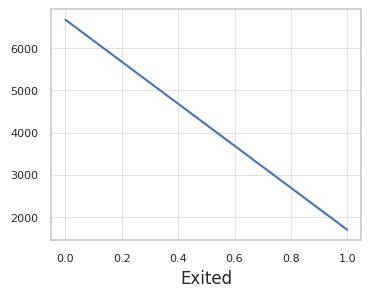

In [18]:
sns.lineplot(data=TargetValues)
plt.ylabel('');

##### 4.3 Exploratory charts

I will choose some columns that I consider most relevant and see how they change with different values ​​of the target variable. In the "Age" column, I'll also group your values ​​into an age range for easier viewing.

In [19]:
AgeGroups = [0, 19, 24, 39, 100]
Labels = ['Teenager', 'Young Adult', 'Adult', 'Older Adult']
RawTrainData['AgeGroup'] = pd.cut(RawTrainData['Age'], bins=AgeGroups, labels=Labels, include_lowest=True)

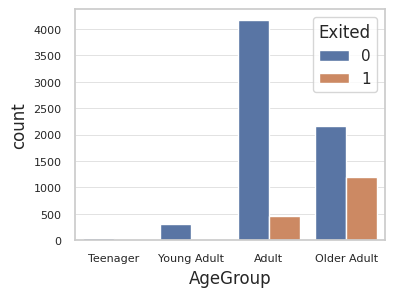

In [20]:
sns.countplot(x='AgeGroup', hue='Exited', data=RawTrainData)
plt.show()

In [21]:
RawTrainData.drop('AgeGroup', axis=1, inplace=True)

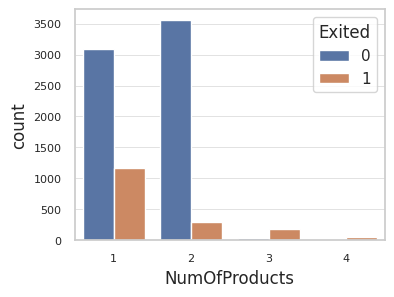

In [22]:
sns.countplot(x='NumOfProducts', hue='Exited', data=RawTrainData)
plt.show()

##### 5. Data Preprocessing

Now, i'm going to manipulate the raw data into a more favorable format. First, I'll remove all unwanted entries (empty rows and duplicates).

In [23]:
df = RawTrainData.copy()

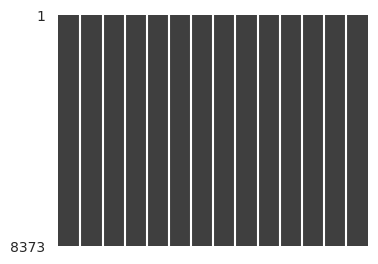

In [24]:
ms.matrix(df, fontsize=8, labels=False, sparkline=False, figsize=(4, 3));

##### 5.1 Categorical encoding
The next step is transform each categorical variable. Each label will be mapped to an integer, making it easier to use these variables in algorithms that require numerical entries.

In [25]:
TextColumns = df.select_dtypes(include=['object', 'category']).columns

In [26]:
le = LabelEncoder()

In [27]:
df[TextColumns] = df[TextColumns].apply(le.fit_transform)

##### 5.2 Correlation
The correlation matrix is ​​a table that shows how variables are related to each other, ranging from -1 to 1. This visualization is essential to identify the most important characteristics of our data.

In [28]:
CorrMatrix = df.corr()

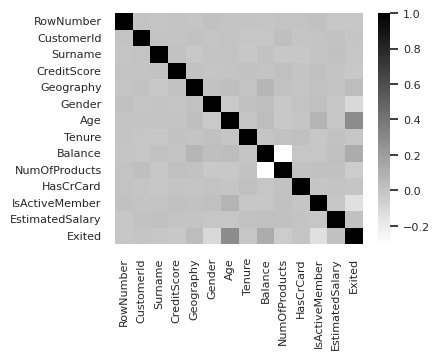

In [29]:
sns.heatmap(CorrMatrix, cmap='binary');

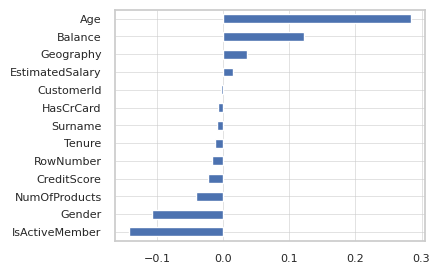

In [30]:
CorrMatrix[target].drop(target).sort_values().plot(kind = "barh");

##### 5.3 Feature engineering
Next, i will reshape our table, selecting only the variables that are most relevant to the problem. I will also remove columns that are very similar to each other to avoid a problem called [multicollinearity](https://pt.wikipedia.org/wiki/Multicolinearidade)


In [31]:
ColumnsToDrop = ['RowNumber', 'CustomerId', 'Surname', 'Gender', 'Tenure', 'HasCrCard']

In [32]:
df.drop(ColumnsToDrop, axis=1, inplace=True)

In [33]:
CountOfCorrelatedColumns = len(CountCorrelatedColumns(CorrMatrix))

In [34]:
print(f'Multicollinearity: {CountOfCorrelatedColumns}')

Multicollinearity: 0


##### 5.4 Outliers
Let's identify the unusual values in the data set for each column.

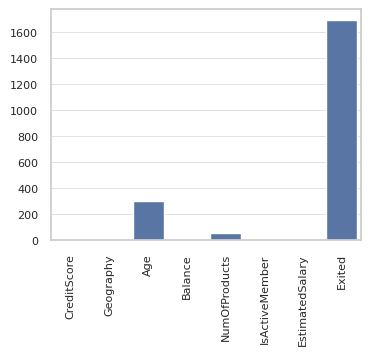

In [35]:
ShowOutliers(df)

##### 5.5 Split the data into train and test sets (holdout)
In this phase, I will separate the predictor variables from the target and also split the data into training and test sets.

In [36]:
X = df.drop(target, axis=1)
y = df[target]

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

<br>

##### 5.6 Feature scaling
Here, I'll adjust the scale of the columns to a range of 0 to 1 with `'MinMaxScaler'`.

In [38]:
scaler = MinMaxScaler()

In [39]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

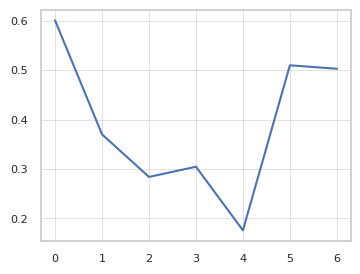

In [40]:
dfMean = pd.DataFrame(X_train).mean()
sns.lineplot(data=dfMean);

<!--
##### 5.7  Class balancing
As the classes of the target variable are unbalanced, I will increase the number of lines in the minority class with the `'oversampling'` strategy.
-->

<!--Let's remove the columns of "rownumber", "customerid", "surname" from the given dataset since they do NOT have any contribution to classification in our analysis


Outliers: Identificados nas colunas **'Credit Score'**, **'Age'**,
**'NumOfProducts'** e **'Exited'**, mas como não são falhas na entrada dos dados (visto no EDA), não os removi.

It can be concluded that there has been weak correlations between the numerical features and the target variable. So, evenif we accept the level of 0.80 as criteria for multicollinearity, it can be concluded that there is no multi-colliniearity problem among the variables". On the other hand it can be safely assumed that while our target variable of 'exited' demonstrates a slight negative correlation with the variables of "creditscore", "tenure", "numberofproducts" 'hascrcard' and 'isactivemember', it demonstrates slight positive correlation with the variables of 'age', 'balance' and 'estimatedsalary"-->

##### 5.7 Class weight
The target variable is unbalanced, so instead of using under- or over-sampling methods, i'm going to assign different weights to the classes, giving more importance to the customers who are going to leave.


In [41]:
ClassWeight = {0: 0.4, 1: 2.4}

<br>

##### 6. Hyperparameter tuning
Selecting the ideal hyperparameters for a machine learning model. Its objective is to improve performance.

In [42]:
ModelsBasic= {
    'RandomForest': RandomForestClassifier(random_state=42, class_weight=ClassWeight, max_depth=5, bootstrap=False),
    'DecisionTree': DecisionTreeClassifier(random_state=42, class_weight=ClassWeight, max_depth=5)
}

In [43]:
RfModel = ModelsBasic['RandomForest']
RfRandomSearch = FindBestParameters(RfModel, {}, X_train, y_train)

In [44]:
DtModel = ModelsBasic['DecisionTree']
DtRandomSearch = FindBestParameters(DtModel, {}, X_train, y_train)

<br>

##### 6.1 Cross validation
Training the models and comparing their performances (recall) with cross validation in order to choose one of them for hyperparameter tuning.

In [45]:
ModelsTunned = {
    'RandomForestTunned': RfRandomSearch.best_estimator_,
    'DecisionTreeTunned': DtRandomSearch.best_estimator_
}

In [46]:
PerfModels = CrossValidation(ModelsTunned, X_train, y_train, Metric='recall')
PerfModelSorted = PerfModels.sort_values(by='recall')

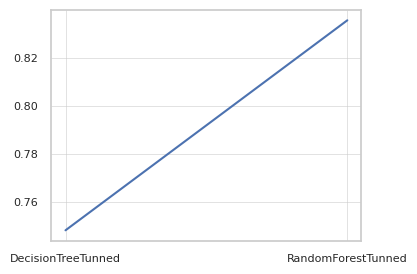

In [47]:
sns.lineplot(x='Model', y='recall', data=PerfModelSorted)
plt.xlabel('')
plt.ylabel('');

##### 6.2 Training
The Random Forest is an ensemble model that combines multiple individual decision trees to create a more robust model. This ensemble method helps to reduce overfitting and improve the model's generalization capacity. On the other hand, decision trees are easier to understand how decisions are made based on customer characteristics. Both models also consider different relationships between variables to predict churn, but as Random Forest had a better recall, I'll choose it.

In [48]:
FinalModelTunned = ModelsTunned['RandomForestTunned']
FinalModelTunned.fit(X_train, y_train);

In [49]:
TrainPred = FinalModelTunned.predict(X_train)
TestPred = FinalModelTunned.predict(X_test)

##### 6.3 Overfitting and underfitting
When a machine learning model fits the training data very well but has difficulty predicting unseen data, the model is memorizing and not learning the patterns, which is an overfitting problem. Now, when a model is too simple to understand the patterns in the data, this is called underfitting and it seems that the model doesn't have either problem.

In [50]:
RecallTrain = recall_score(y_train, TrainPred)
RecallTest = recall_score(y_test, TestPred)

In [51]:
print('Recall/Train:' , RecallTrain)
print('Recall/Test:', RecallTest)

Recall/Train: 0.8649446494464945
Recall/Test: 0.8584070796460177


In [52]:
TrainError = mean_squared_error(y_train, TrainPred)
TestError = mean_squared_error(y_test, TestPred)

In [53]:
print('Train error:', TrainError)
print('Test error:', TestError)

Train error: 0.3020304568527919
Test error: 0.2764179104477612


##### 6.4 Cofunsion Matrix
Confusion matrix is a table used to evaluate the performance of a model, showing the count of true positives, true negatives, false positives and false negatives.

In [54]:
ConfusionMatrix = confusion_matrix(y_test, TestPred)

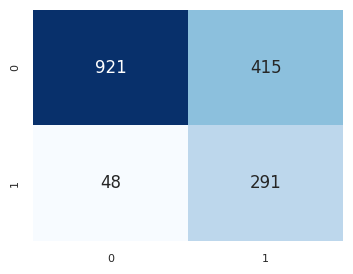

In [55]:
sns.heatmap(ConfusionMatrix, annot=True, fmt='d', cmap='Blues',cbar=False)
plt.show()

##### 6.5 Tradeoff recall/precision

When the probability of a prediction is greater than 0.5, the instance is classified as positive, if not, it is classified as negative.

So, if my priority is to find customers who will leave in the future, I could lower the threshold to maximize recall, even if I had to sacrifice the precision of my model.

This could be my decision, because the cost of losing a customer is much higher than the cost of retaining a customer who wasn't really thinking about canceling.

In [56]:
Proba = FinalModelTunned.predict_proba(X_test)
Precision, Recall, Threshold = precision_recall_curve(y_test, Proba[:, 1])

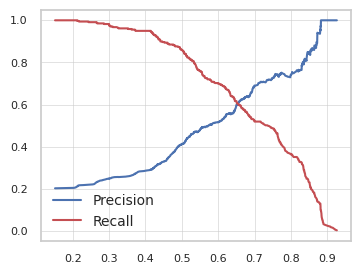

In [57]:
plt.plot(Threshold, Precision[:-1], 'b-', label='Precision')
plt.plot(Threshold, Recall[:-1], 'r-', label='Recall')
plt.legend(loc='lower left', fontsize='small', frameon=False);

##### 6.6 ROC and AUC
Used to measure the performance of binary classification models, the ROC is a graphical representation of the model's performance, while the AUC quantifies it.

In [58]:
Fpr, Tpr, _ = roc_curve(y_test, Proba[:, 1])
RocAuc = roc_auc_score(y_test, Proba[:, 1])

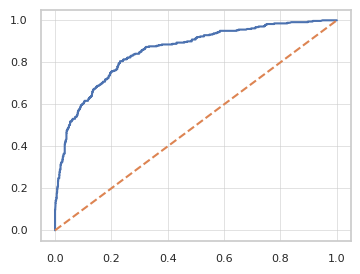

In [59]:
plt.plot(Fpr, Tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

In [60]:
RocAuc

0.8543852560365993

##### 6.7 Feature importances
I will look at feature importances below in order to interpret which features provide the most predictive power for the model.

In [61]:
Importance = FinalModelTunned.feature_importances_
SortedIndex = np.argsort(Importance)

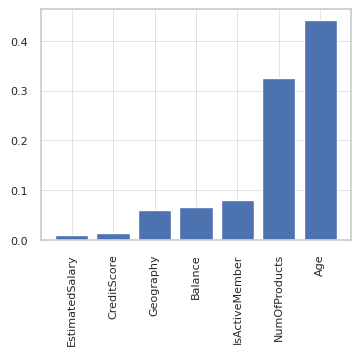

In [62]:
plt.bar(X.columns[SortedIndex], Importance[SortedIndex])
plt.xticks(rotation=90)
plt.show()

In [63]:
Model = FinalModelTunned

##### 7. Prediction
The trained model will be used to predict new data.
With this, I will reach the main objective of the project (anticipate the churn of the bank's customers).

In [64]:
UrlTest = 'https://raw.githubusercontent.com/mouraxy/data/main/raw/BankCustomersTest.csv'
RawTestData = pd.read_csv(UrlTest)

In [65]:
Features = RawTestData.drop(target, axis=1)
Target = RawTestData[target]

In [66]:
TextColumns = Features.select_dtypes(include=['object']).columns
TextColumns;

In [67]:
Features[TextColumns] = Features[TextColumns].apply(le.fit_transform)
Features[TextColumns];

In [68]:
Features.drop(ColumnsToDrop, axis=1, inplace=True)
FeaturesScaled = scaler.transform(Features)

In [69]:
ProbaTest = Model.predict_proba(FeaturesScaled)[:, 1]
PredTest = Model.predict(FeaturesScaled)

#####7.1 Recall and Model error
For financial return, "Recall" will be useful to measure the model's ability to correctly identify customers who will leave. In contrast, the "ModelError" is the rate of customers who would incorrectly participate in the retention program (the model predicted wrong for these users).

In [70]:
EnrichedTestData = RawTestData.copy()

In [71]:
EnrichedTestData['Pred'] = PredTest
EnrichedTestData['ProbaCustomerChurn'] = ProbaTest
EnrichedTestData['PredCorrect'] = EnrichedTestData['Pred'] == Target

In [72]:
TargetTest = EnrichedTestData['Exited']
TargetTrue = EnrichedTestData[EnrichedTestData['Exited'] == 1]
PredTrue = EnrichedTestData[EnrichedTestData['Pred'] == 1]

In [73]:
Recall = recall_score(TargetTest, PredTest)
ModelError = 1 - precision_score(TargetTest, PredTest)

#####8. Financial return
In general, banks' profits depend on several factors such as investments, loans and the rates and interest associated with these products and services. So I'll estimate 100 dollars per customer on a user base of 5 million.

In [74]:
ProfitPerUser = 100
CustomerBase = 5000000

#####8.1 Churn rate
If I assume that the proportion of customers leaving the bank is the same as the data used here, then 21.08% of users will churn.

In [75]:
ChurnRate= len(TargetTrue)/len(EnrichedTestData)
ChurnRate

0.21081745543945912

#####8.2 Churn cost
The bank will lose ~$105,408,727 if no campaign is created in the future. This is very bad, but it is the pain point I have to attack and it is the main reason for building this model itself.

In [76]:
LostProfit = ProfitPerUser*(CustomerBase * ChurnRate)
LostProfit

105408727.71972956

#####8.3 Profit saved by the model
To calculate the profit that my model can save, I must calculate the *(recall value * lost profit) * retention campaign success percentage*. First, I'll assume a rate of 50%.

In [77]:
RetentionRate = 0.5

In [78]:
SavedProfit = (LostProfit*Recall)*RetentionRate
SavedProfit

46404425.32267977

#####8.4 Costs generated by the model
The model can also generate unwanted costs, such as wasted time and money on customers that the model predicted wrong. So, I will assume that in the retention campaign the bank will spend 5 dollars and 25 minutes of attention per customer. These expenses are in bonus programs, discounts and contacts via the call center/managers.

In [79]:
ModelTrueChurn = len(PredTrue)/len(EnrichedTestData)

In [80]:
CustomersPredChurn = ModelTrueChurn * CustomerBase
CustomersPredChurn

2384757.2218807624

In [81]:
HoursCost = (CustomersPredChurn * 25)/60
HoursCost

993648.8424503176

In [82]:
ModelCost = CustomersPredChurn * 5
ModelCost

11923786.109403811

#####8.5 Results
Finally, if I consider that the bank has 5000 full time employees trying to convince these customers, I know that the profit maintained thanks to the model is equal to the *profit recovered - the cost of the model*.

In [83]:
ProfitSavedByModel = SavedProfit - ModelCost
print('Profit retained in the bank using the model:', ProfitSavedByModel)

Profit retained in the bank using the model: 34480639.21327596


In [84]:
ProfitSavedByModelPerc = ProfitSavedByModel/LostProfit
print(f'Percentage of profit retained in the bank using the model : {ProfitSavedByModelPerc*100}%')

Percentage of profit retained in the bank using the model : 32.711370262390666%


#####8.5.1 Different weights
To finalize the project, I'll pass a list of values to the variables, instead of a fixed number as before. With this, I can see the different effects of profit, time and capacity.

In [85]:
RetentionRates = np.linspace(0, 1.0)
ProfitsRetained = []

In [86]:
for RetentionRate in RetentionRates:
    SavedProfit = (LostProfit * Recall) * RetentionRate
    ProfitSavedByModel = SavedProfit - ModelCost
    ProfitsRetained.append(ProfitSavedByModel)

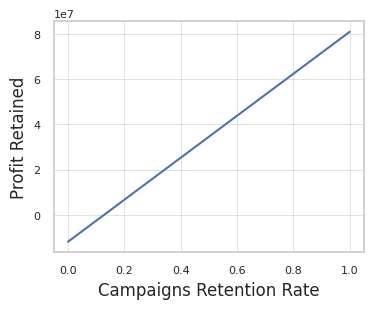

In [87]:
plt.plot(RetentionRates, ProfitsRetained)
plt.xlabel('Campaigns Retention Rate')
plt.ylabel('Profit Retained');

In [88]:
Capacity = [500, 2000, 3000, 5000, 10000]
HoursPerDay = 8
Days= []

In [89]:
for Colab in Capacity:
    HoursNeeded = HoursCost / Colab
    DaysNeeded = HoursNeeded / HoursPerDay
    Days.append(DaysNeeded)

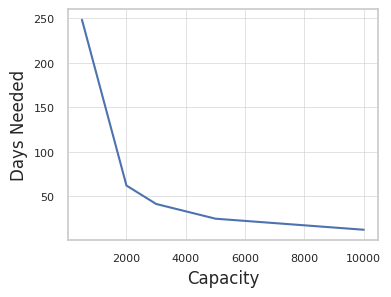

In [90]:
plt.plot(Capacity, Days)
plt.xlabel('Capacity')
plt.ylabel('Days Needed');

#####9. Conclusion

Both models achieved a high recall, close to 90%, but with a significant number of false positives and not such high precision. However, the costs generated by the model are much lower than the money that would be retained. So the final model is financially viable for the bank.

The main variables that influence the bank's customer exit are the age of its customers and the number of products in their portfolios.

As my suggestion, to avoid false positives and their associated costs, the positive results of the model can be validated with other variables that were not in the training data, such as the number of calls opened in the call center and other indicators of customer satisfaction (CSAT).

The bank can also encourage customers to have an average of 2 products per portfolio and offer highly personalized services for customers over 40 years old. These measures together with retention and loyalty programs can prevent them from deactivating their accounts.